In [15]:
%pip install -q transformers
%pip install -q datasets
%pip install -q evaluate
%pip install -q accelerate
%pip install -q gluonts ujson

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [16]:
!curl -O https://raw.githubusercontent.com/abbyzak/Transformer_TSA/refs/heads/main/get_create_loader.py
!curl -O https://raw.githubusercontent.com/abbyzak/Transformer_TSA/refs/heads/main/make_model.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  4688  100  4688    0     0  19474      0 --:--:-- --:--:-- --:--:-- 19864
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  4350  100  4350    0     0  24947      0 --:--:-- --:--:-- --:--:-- 25438
100  4350  100  4350    0     0  24930      0 --:--:-- --:--:-- --:--:-- 25438


In [30]:
from datasets import load_dataset
from gluonts.time_feature import time_features_from_frequency_str
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

# Load the Monash dataset
dataset = load_dataset("monash_tsf", "wind_farms_minutely", trust_remote_code=True)
freq = "1M"
prediction_length = 24
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# Define the model configuration
lags_sequence = [1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]
time_features = time_features_from_frequency_str(freq)
config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    context_length=prediction_length * 2,
    lags_sequence=lags_sequence,
    num_time_features=len(time_features) + 1,
    num_static_categorical_features=1,
    cardinality=[len(train_dataset)],
    embedding_dimension=[2],
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

# Create the model
model = TimeSeriesTransformerForPrediction(config)

c:\Users\sbark\anaconda3\envs\gpu\lib\site-packages\gluonts\time_feature\_base.py:249: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = to_offset(freq_str)


In [31]:
from make_model import create_train_dataloader, create_test_dataloader

train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

In [32]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
from matplotlib import pyplot

torch.manual_seed(0)
np.random.seed(0)

# This concept is also called teacher forcing.
# The flag decides if the loss will be calculated over all or just the predicted values.
calculate_loss_over_all_values = False

# S is the source sequence length
# T is the target sequence length
# N is the batch size
# E is the feature number

#src = torch.rand((10, 32, 512)) # (S,N,E)
#tgt = torch.rand((20, 32, 512)) # (T,N,E)
#out = transformer_model(src, tgt)
#
#print(out)

input_window = 100
output_window = 5
batch_size = 10 # batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]


class TransAm(nn.Module):
    def __init__(self,feature_size=250,num_layers=1,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask



# if window is 100 and prediction step is 1
# in -> [0..99]
# target -> [1..100]
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = np.append(input_data[i:i+tw][:-output_window] , output_window * [0])
        train_label = input_data[i:i+tw]
        #train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

"""def get_data():
    time        = np.arange(0, 400, 0.1)
    # amplitude   = np.sin(time) + np.sin(time*0.05) +np.sin(time*0.12) *np.random.normal(-0.2, 0.2, len(time))
    amplitude   = np.sin(time) + np.sin(time*0.05) +np.sin(time*0.12) *np.random.normal(-0.5, 0.5, len(time))


    #from pandas import read_csv
    #series = read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    #amplitude = scaler.fit_transform(series.to_numpy().reshape(-1, 1)).reshape(-1)
    amplitude = scaler.fit_transform(amplitude.reshape(-1, 1)).reshape(-1)


    sampels = 2800
    train_data = amplitude[:sampels]
    test_data = amplitude[sampels:]

    # convert our train data into a pytorch train tensor
    #train_tensor = torch.FloatTensor(train_data).view(-1)
    # todo: add comment..
    train_sequence = create_inout_sequences(train_data,input_window)
    train_sequence = train_sequence[:-output_window] #todo: fix hack?

    #test_data = torch.FloatTensor(test_data).view(-1)
    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window] #todo: fix hack?

    return train_sequence.to(device),test_data.to(device)"""

def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
    return input, target


def train(train_data):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)

        if calculate_loss_over_all_values:
            loss = criterion(output, targets)
        else:
            loss = criterion(output[-output_window:], targets[-output_window:])

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def plot_and_loss(eval_model, data_source,epoch):
    eval_model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i,1)
            # look like the model returns static values for the output window
            output = eval_model(data)
            if calculate_loss_over_all_values:
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-output_window:], target[-output_window:]).item()

            test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)

    #test_result = test_result.cpu().numpy()
    len(test_result)

    pyplot.plot(test_result,color="red")
    pyplot.plot(truth[:500],color="blue")
    pyplot.plot(test_result-truth,color="green")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-epoch%d.png'%epoch)
    pyplot.close()

    return total_loss / i


def predict_future(eval_model, data_source,steps):
    eval_model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)
    _ , data = get_batch(data_source, 0,1)
    with torch.no_grad():
        for i in range(0, steps,1):
            input = torch.clone(data[-input_window:])
            input[-output_window:] = 0
            output = eval_model(data[-input_window:])
            data = torch.cat((data, output[-1:]))

    data = data.cpu().view(-1)


    pyplot.plot(data,color="red")
    pyplot.plot(data[:input_window],color="blue")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-future%d.png'%steps)
    pyplot.close()

# entweder ist hier ein fehler im loss oder in der train methode, aber die ergebnisse sind unterschiedlich
# auch zu denen der predict_future
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)
            if calculate_loss_over_all_values:
                total_loss += len(data[0])* criterion(output, targets).cpu().item()
            else:
                total_loss += len(data[0])* criterion(output[-output_window:], targets[-output_window:]).cpu().item()
    return total_loss / len(data_source)

#train_data, val_data = get_data()
model = TransAm().to(device)

criterion = nn.MSELoss()
lr = 0.005
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

best_val_loss = float("inf")
epochs = 100 # The number of epochs
best_model = None

# for epoch in range(1, epochs + 1):
#     epoch_start_time = time.time()
#     train(train_data)


#     if(epoch % 10 is 0):
#         val_loss = plot_and_loss(model, val_data,epoch)
#         predict_future(model, val_data,200)
#     else:
#         val_loss = evaluate(model, val_data)

#     print('-' * 89)
#     print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
#                                      val_loss, math.exp(val_loss)))
#     print('-' * 89)

#     #if val_loss < best_val_loss:
#     #    best_val_loss = val_loss
#     #    best_model = model

    # scheduler.step()


from make_model import *
#src = torch.rand(input_window, batch_size, 1) # (source sequence length,batch size,feature number)
#out = model(src)
#
#print(out)
#print(out.shape)

c:\Users\sbark\anaconda3\envs\gpu\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [33]:
# perform forward pass
batch = next(iter(train_dataloader))
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

In [34]:
print("Loss:", outputs.loss.item())

Loss: 6.638230800628662


very bad loss lets train it

In [35]:
from accelerate import Accelerator
from torch.optim import AdamW

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(40):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        if idx % 100 == 0:
            print(loss.item())

6.541467666625977
7.374013900756836
7.1647210121154785
7.416309833526611
6.782454013824463
7.3729119300842285
7.298133850097656
7.090139865875244
7.4195637702941895
7.433479309082031
6.995906829833984
6.705647945404053
7.374444484710693
7.953214645385742
6.513030529022217
7.390160083770752
6.866247653961182
6.716858386993408
6.675063610076904
6.687843322753906
7.165853023529053
6.586470127105713
7.57638692855835
6.751514911651611
6.975917816162109
7.184999942779541
6.6428961753845215
6.847520351409912
7.402719020843506
6.742400646209717
7.420987606048584
7.030129909515381
6.937585353851318
7.23931360244751
6.815288543701172
7.5693182945251465
6.868162631988525
7.542844772338867
7.348748683929443
7.283541202545166


In [41]:
for idx, batch in enumerate(train_dataloader):
    print(f"Batch shape: {batch['past_values'].shape}")
    print(f"Sample data: {batch['past_values'][0][:10]}")
    break

Batch shape: torch.Size([256, 85])
Sample data: tensor([ 0.,  0.,  0.,  0.,  0.,  4.,  8., 24., 20., 16.])


In [36]:
device = torch.device('cpu')
model = model.to(device)

model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

We'll stack them vertically, to get forecasts for all time-series in the test dataset:

In [37]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(366, 100, 24)


In [38]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
smape_metrics = []
for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq),
    )
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])

print(f"MASE: {np.mean(mase_metrics)}")
print(f"sMAPE: {np.mean(smape_metrics)}")

c:\Users\sbark\anaconda3\envs\gpu\lib\site-packages\gluonts\time_feature\seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
c:\Users\sbark\anaconda3\envs\gpu\lib\site-packages\gluonts\time_feature\seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
c:\Users\sbark\anaconda3\envs\gpu\lib\site-packages\gluonts\time_feature\seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
c:\Users\sbark\anaconda3\envs\gpu\lib\site-packages\gluonts\time_feature\seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
c:\Users\sbark\anaconda3\envs\gpu\li

MASE: 1.3891638208532902
sMAPE: 0.16983821184456593


c:\Users\sbark\anaconda3\envs\gpu\lib\site-packages\gluonts\time_feature\seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
c:\Users\sbark\anaconda3\envs\gpu\lib\site-packages\gluonts\time_feature\seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
c:\Users\sbark\anaconda3\envs\gpu\lib\site-packages\gluonts\time_feature\seasonality.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)


In [39]:
import matplotlib.dates as mdates


def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(
        index[-2 * prediction_length :],
        test_dataset[ts_index]["target"][-2 * prediction_length :],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:],
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )

    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0),
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0),
        alpha=0.3,
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.show()

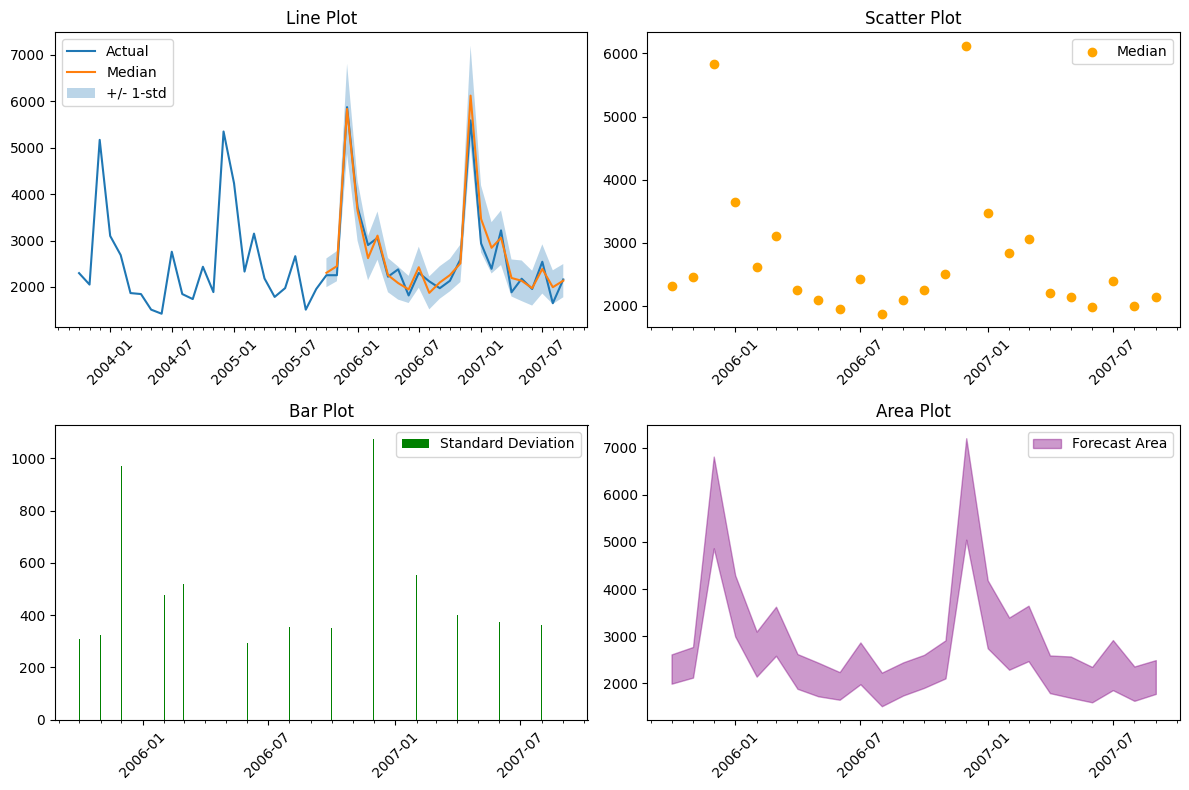

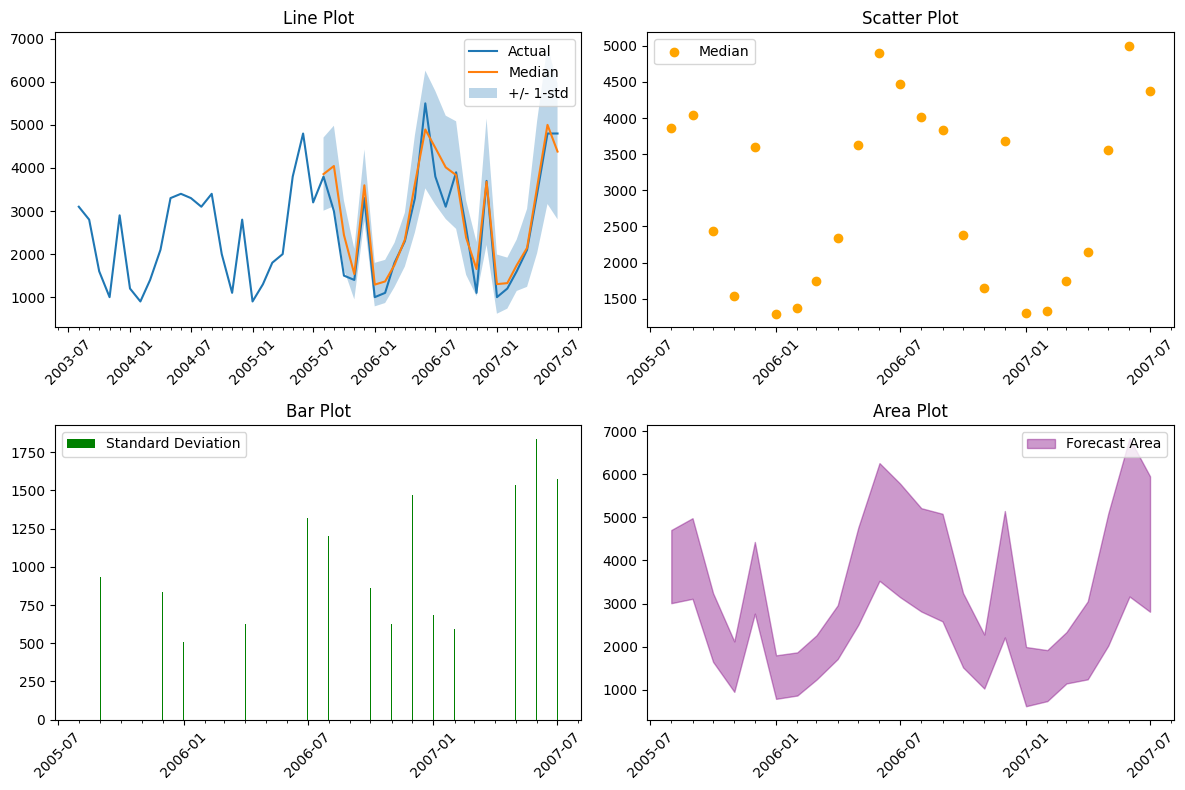

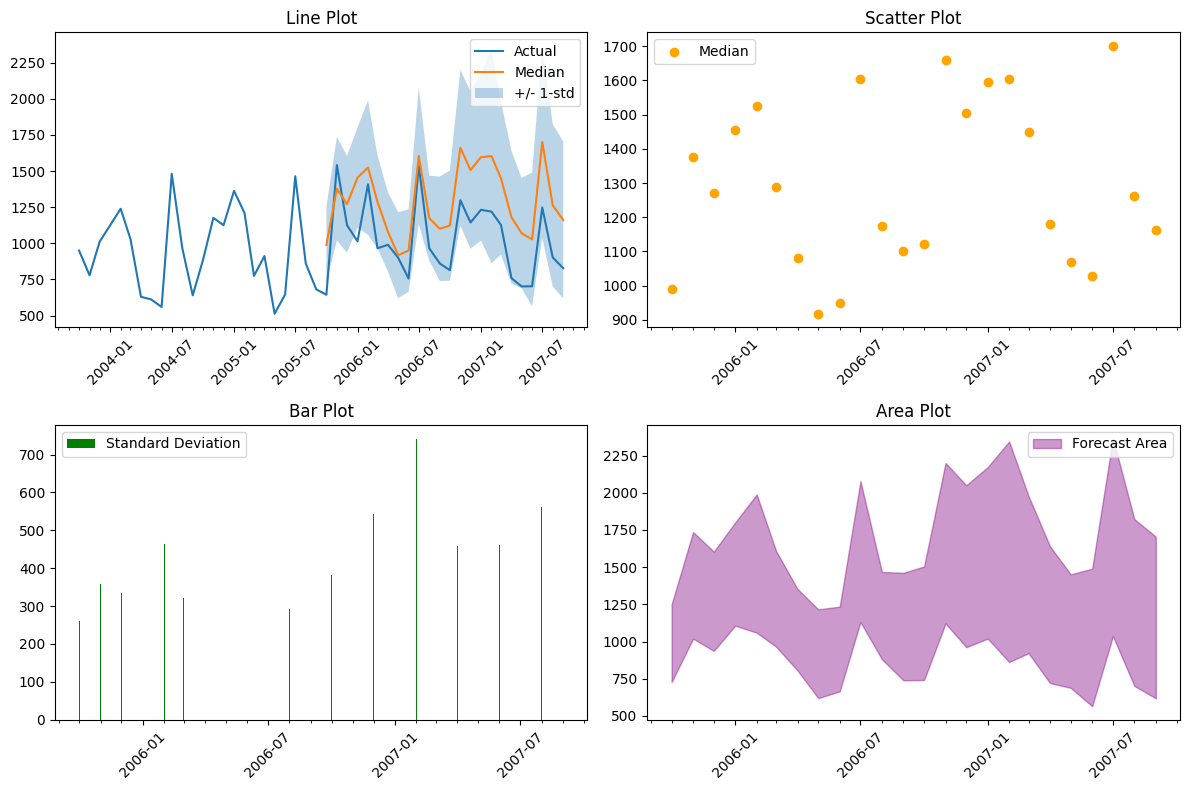

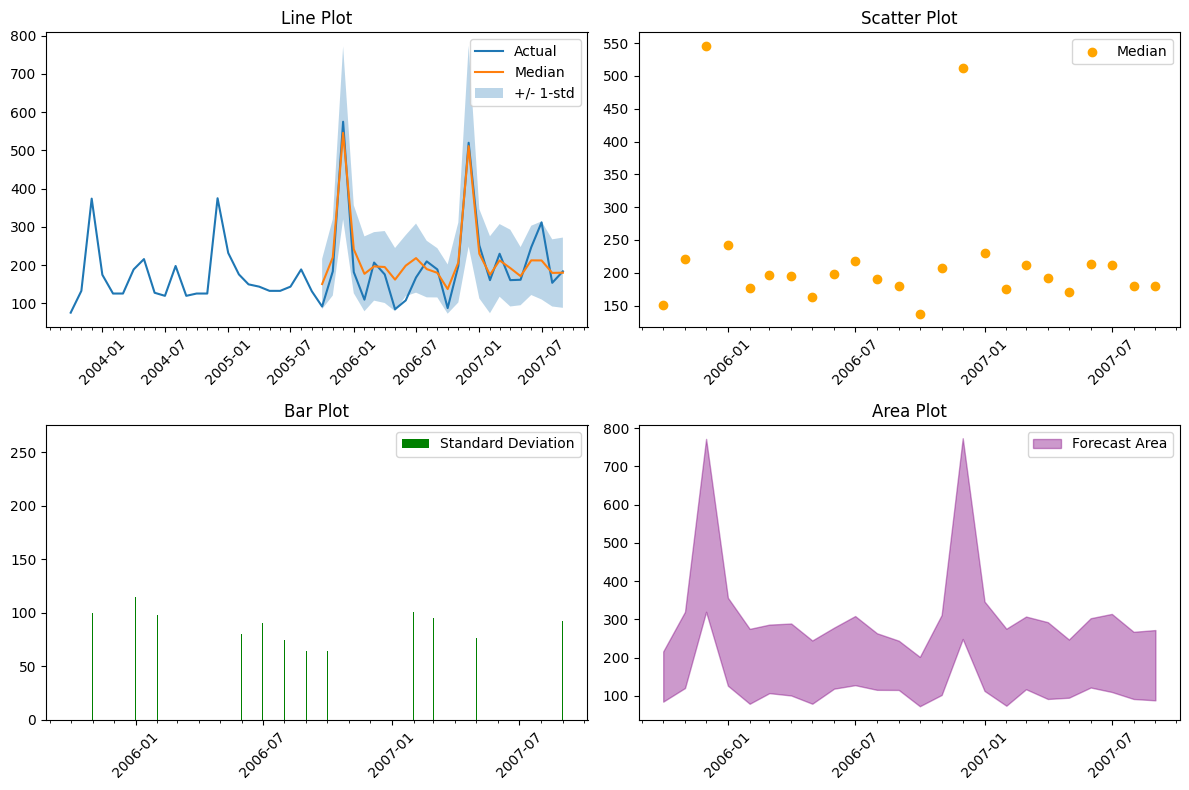

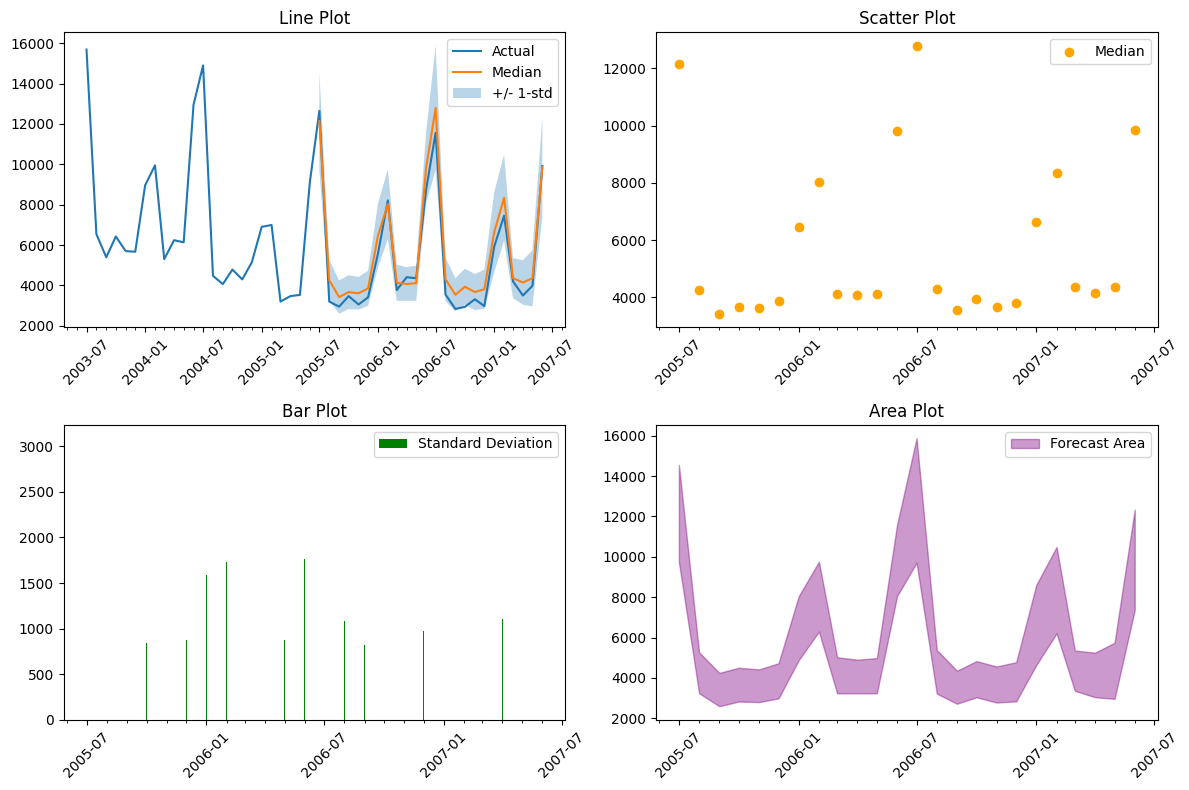

In [40]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

def grid_plots(ts_index, test_dataset, forecasts, freq, prediction_length):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    index = pd.period_range(
        start=test_dataset[ts_index]["start"],
        periods=len(test_dataset[ts_index]["target"]),
        freq=freq,
    ).to_timestamp()

    actual = test_dataset[ts_index]["target"][-2 * prediction_length :]
    forecast_median = np.median(forecasts[ts_index], axis=0)
    forecast_std = forecasts[ts_index].std(axis=0)

    # Line Plot
    axes[0].plot(index[-2 * prediction_length:], actual, label="Actual")
    axes[0].plot(index[-prediction_length:], forecast_median, label="Median")
    axes[0].fill_between(
        index[-prediction_length:],
        forecast_median - forecast_std,
        forecast_median + forecast_std,
        alpha=0.3,
        label="+/- 1-std"
    )
    axes[0].set_title("Line Plot")
    axes[0].legend()

    # Scatter Plot
    axes[1].scatter(
        index[-prediction_length:], forecast_median, color="orange", label="Median"
    )
    axes[1].set_title("Scatter Plot")
    axes[1].legend()

    # Bar Plot
    axes[2].bar(
        index[-prediction_length:], forecast_std, color="green", label="Standard Deviation"
    )
    axes[2].set_title("Bar Plot")
    axes[2].legend()

    # Area Plot
    axes[3].fill_between(
        index[-prediction_length:],
        forecast_median - forecast_std,
        forecast_median + forecast_std,
        color="purple",
        alpha=0.4,
        label="Forecast Area"
    )
    axes[3].set_title("Area Plot")
    axes[3].legend()

    # Format x-axis for all subplots
    for ax in axes:
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.tick_params(axis="x", rotation=45)

    fig.tight_layout()
    plt.show()

# Example usage:
grid_plots(334, test_dataset, forecasts, freq, prediction_length)
grid_plots(123, test_dataset, forecasts, freq, prediction_length)
grid_plots(234, test_dataset, forecasts, freq, prediction_length)
grid_plots(202, test_dataset, forecasts, freq, prediction_length)
grid_plots(101, test_dataset, forecasts, freq, prediction_length)




In [45]:
import numpy as np
import pandas as pd

forecast_median = np.median(forecasts, axis=1)

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'actual': np.concatenate([ts['target'][-prediction_length:] for ts in test_dataset]),
    'forecast': forecast_median.flatten(),
})

# Calculate error
results_df['error'] = results_df['forecast'] - results_df['actual']

# Add error metrics
results_df['MASE'] = mase_metrics
results_df['sMAPE'] = smape_metrics

# Save the results to a CSV file
results_df.to_csv('forecast_results.csv', index=False)

print("Results saved to forecast_results.csv")


import os

if os.path.exists('forecast_results.csv'):
    print("File created successfully")
    print(pd.read_csv('forecast_results.csv').head())
else:
    print("File creation failed")


ValueError: Length of values (366) does not match length of index (8784)